<h3>Unsupervised Learning: Dimensionality Reduction, FAMD</h3>
The purpose of this notebook is to read in the CDC survey data and try different dimensionality reduction methods on it to see if we can reduce the complexity of the dataset. The dataset has ~300 columns, we reduce that to 30 columns that we manually choose. Although 30 columns is less complex than 300 complex we want to reduce the complexity even further.

In [2]:
import pandas as pd
import numpy as np
from prince import FAMD, MCA
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [4]:
#Set random_state for reproducible results
RANDOM_SEED = 42

In [5]:
# Read in DataFrame
df = pd.read_csv('NYSDOH_BRFSS_SurveyData_2020.csv', encoding = 'cp1252')

C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (39,151,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The dataset is pretty clean, however there are some columns where majority of the values are missing and we want to drop those columns to start with.

In [6]:
# Use df_clean for cleaning
df_clean = df.copy()

# Repalce 'Not asked or Missing' and 'Data do not meet the criteria for statistical reliability, 
# data quality or confidentiality (data are suppressed)' with NA
for col in df.columns:
    df_clean[col].replace({'Not asked or Missing' : np.nan}, inplace = True)
    df_clean[col].replace({'Data do not meet the criteria for statistical reliability, data quality or confidentiality (data are suppressed)' : np.nan}, inplace = True)
    
# Drop columns with over 80% missing values
df_clean.dropna(axis = 1, thresh = len(df_clean) * .50, inplace = True)

First we want to try manually selecting columns from the dataset based on literature that discusses which lifestyle questions are generally attributed to an increased risk of heart attacks. The sources used are listed in the next code block.

In [7]:
# Select relevant columns related to heart disease by utilizing resources detailing factors of heart disease
# shorturl.at/oqwF5 - Behavioral risk factors of coronary artery disease: A paired matched case control study
# shorturl.at/cpAXZ - Strategies to prevent heart disease
# shorturl.at/gpwAR - Top five habits that harm the heart
# shorturl.at/mtJUZ - 9 Common Habits That Are Bad for Your Heart

# Characteristics
# 1. SEXVAR - Sex - (Male or Female)
# 2. _IMPAGE - Age - (Age 65 or older, Age 55 - 64, Age 45 - 54, Age 35 - 44, Age 25 - 34, Age 18 - 24)
# 3. _IMPRACE - Race - (White, Non-Hispanic, Hispanic, Black, Non-Hispanic, Other race, Non-Hispanic, Asian, Non-Hispanic,
# American Indian/Alaskan Native, Non-Hispanic)
# 4. VETERAN3 - Former veteran status - (Yes, No, Refused, Don't know/Not sure)
# 5. WTKG3 - Weight in KG - (Continous value)
# 6. _IMPMRTL - Marital status - (Married, Never Married, Divorced, Widowed, A member of an unmarried couple, 
# Separated)
# 7. _RFBMI5 - Overweight or Obese - (Yes, No, Don’t know/Refused/Missing)


# Health 
# 8. HLTHPLN1 - Has Healthcare Coverage - (Yes, No, Don't know/Not sure, Refused)
# 9. ADDEPEV3 - Diagnosed with depression - (Yes, No, Don't know/Not sure, Refused)
# 10. DIABETE4 - Diagnosed with diabetes - (Yes, Yes, but female told only during pregnancy, 
# No, pre-diabetes or borderline diabetes, No, Don't know/Not sure, Refused)
# 11. RMVTETH4 - Number of teeth removed - All, 6 or more, but not all, 1 to 5, None, Don't know/Not sure, Refused
# 12. _PHYS14D - Number of days physical health not well - (Zero days when physical health not good,     
# 1-13 days when physical health not good, 14+ days when physical health not good, Don’t know/Refused/Missing)                 
# 13. _MENT14D - Number of days mental health not well - Zero days when mental health not good
# 1-13 days when mental health not good, 14+ days when mental health not good, Don’t know/Refused/Missing    
# 14. _TOTINDA - Physical activity - (Had physical activity or exercise, No physical activity or exercise in last 30 days,     
# Don’t know/Refused/Missing)       
# 15. PDIABTST - User has gotten a test for high blood sugar in past 3 years - (Yes, No, Don't know/Not sure, Refused)
# 16. PREDIAB1 - Diagnosed as prediabetic - Yes, Yes, during pregnancy, Don't know/Not Sure, Refused, No
# 17. _RFHLTH - General health - (Good or Better Health, Fair or Poor Health, Don’t know/Not Sure Or Refused/Missing)
# 18. BPHIGH4 - (Told they have high blood pressure - Yes, Told borderline high or pre-hypertensive, 
# Yes, but female told only during pregnancy, Don't Know/Not Sure Refused, No) 

# Lifestyle
# 19. CHECKUP1 - Length since last checkup - (Within past year (anytime less than 12 months ago), 
# Within past 2 years (1 year but less than 2 years ago), Within past 5 years (2 years but less than 5 years ago), 
# 5 or more years ago, Don’t know/Not sure, Never, Refused)
# 20. LASTDEN4 - Last visited dentist - (Within past year (anytime less than 12 months ago), 
# Within past 2 years (1 year but less than 2 years ago), Within past 5 years (2 years but less than 5 years ago), 
# 5 or more years ago, Don’t know/Not sure, Never, Refused)
# 21. FLUSHOT7 - Whether someone has taken the flu shot - (Yes, No, Don't know/Not sure, Refused)
# 22. _RFSEAT3 - Seatbeat wearing status - (Always Wear Seat Belt, Don’t Always Wear Seat Belt
# Don’t know/Not Sure Or Refused/Missing)

# Socioeconomic status
# 23. _IMPEDUC - Education - (College 4 years or more (College graduate), 
# College 1 year to 3 years (Some college or technical school), Grade 12 or GED (High school graduate), 
# Grades 9 through 11 (Some high school), Grades 1 through 8 (Elementary), Never attended school or only kindergarten)
# Grades 9 through 11 (Some high school), Grades 1 through 8 (Elementary), Never attended school or only kindergarten)
# 24. EMPLOY1 - 
# 25. _INCOMG - Income level - ($50,000 or more, Don’t know/Not sure/Missing, $15,000 to less than $25,000,   
# $35,000 to less than $50,000, $25,000 to less than $35,000, Less than $15,000)
# 26. _METSTAT - Whether they live in a metropolitan - (1, 2)

# Tobacco, Alcohol
# 27. USENOW3 - Use of smokeless tobacco - (Not at all, Some days, Every day, Refused, Don’t know/Not Sure) 
# 28. ECIGARET - E-ciggarette usage - (Yes, No, Don't know/Not sure, Refused)
# 29. _SMOKER3 - Smoking status - (Current smoker - now smokes every day, Current smoker - now smokes some days,
# Former smoker, Never smoked, Don’t know/Refused/Missing
# 30. _RFBING5 - Binge drinking status - (Yes, No, Don’t know/Refused/Missing)                

# Columns to keep - Response variable
# 31. CVDCRHD4 - Ever diagnosed with heart attack - (Yes, No, Don't know/Not sure, Refused)
# 32. CVDCRHD4 - Ever diagnosed with angina/ coronary heart disease - (Yes, No, Don't know/Not sure, Refused)

# For now we will predict heart disease
df_clean_columns = df_clean[['SEXVAR', '_IMPAGE', '_IMPRACE', 'VETERAN3', 'WTKG3', '_IMPMRTL', '_RFBMI5', 
                             'HLTHPLN1', 'ADDEPEV3', 'DIABETE4', 'RMVTETH4', '_PHYS14D', '_MENT14D', '_TOTINDA',
                             'PDIABTST', 'PREDIAB1', '_RFHLTH', 'BPHIGH4', 'CHECKUP1', 'LASTDEN4', 'FLUSHOT7', 
                             '_RFSEAT3', '_IMPEDUC', 'EMPLOY1', '_INCOMG', '_METSTAT', 'USENOW3', 'ECIGARET',
                             '_SMOKER3', '_RFBING5', 'CVDCRHD4']]

In [8]:
# Drop all missing values
df_cleaned = df_clean_columns.dropna(axis = 0).reset_index(drop = True)

# Drop all rows that are Don't know/Not sure or Refused for column we are predicting
df_cleaned = df_cleaned.loc[(df_cleaned['CVDCRHD4'] == 'No') | (df_cleaned['CVDCRHD4'] == 'Yes')]

# Split into X and y
X = df_cleaned.loc[:, df_cleaned.columns != 'CVDCRHD4']
y = df_cleaned['CVDCRHD4']

# Split the data into training and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3,random_state = 42)

Handling Imbalanced Data <br />
Our data is very imbalanced. Only about 4% of the data is for people who have said that they have experienced a heart attack before. Because of this, we need to balance out our data. The two ways we will try to accomplish that is with SMOTE and upsampling. We will try both methods and see which method produces better scores when our models are built later.

In [9]:
#SMOTE using imblearn library

os = SMOTENC(categorical_features = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29], random_state = 0)
os_data_X , os_data_y = os.fit_resample(X_train, y_train)

#Upsampling using resample
#create two different dataframe of majority and minority class 
training_data = pd.DataFrame(X_train)
training_data['CVDCRHD4'] = y_train
df_majority = training_data[(training_data['CVDCRHD4']=='No')] 
df_minority = training_data[(training_data['CVDCRHD4']=='Yes')] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_majority), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
X_train_upsampled = df_upsampled.loc[:, df_cleaned.columns != 'CVDCRHD4']
y_train_upsampled = df_upsampled['CVDCRHD4']

In [10]:
# Find optimal number of components for FAMD
optimal_components = pd.DataFrame(columns = ['num_components', 'explained_variance'])

for i in range(1, 151):
    
    # Get val of x
    num_components = i
    
    # Initialize FAMD
    famd = FAMD(n_components = i, n_iter = 3, random_state = 42)
    famd.fit_transform(X_train)
    
    # Calculate explained variance
    explained_variance = famd.explained_inertia_.sum()
    
    # Insert into dataframe
    row = {'num_components': num_components, 'explained_variance' : explained_variance}
    optimal_components = optimal_components.append(row, ignore_index = True)
    
fig = px.scatter(optimal_components, x = 'num_components', y = 'explained_variance')
fig.show()

# Print max 
optimal_components.loc[optimal_components['explained_variance'] == optimal_components['explained_variance'].max()]

,num_components,explained_variance
108,109.0,1.0
121,122.0,1.0
122,123.0,1.0
123,124.0,1.0


In [11]:
# Initialize FAMD
famd = FAMD(n_components = 120, n_iter = 3, random_state = 42)
famd.fit_transform(X_train)

famd_explained_variance = famd.explained_inertia_
df_famd_explained = pd.DataFrame(famd_explained_variance)
df_famd_explained['component'] = list(range(1, 121))
df_famd_explained.columns = ['explained_variance', 'component']

In [12]:
# Explained variance for each component

fig = px.bar(df_famd_explained, x = 'component', y = 'explained_variance')
fig

In [13]:
famd_correlations_top_10_0 = famd.column_correlations(X_train)[0].sort_values(ascending=False)[0:10]
famd_correlations_top_10_labels_0 = list(famd_correlations_top_10_0.index.values)
famd_correlations_top_10_values_0 = list(famd_correlations_top_10_0.values)

famd_correlations_top_10_1 = famd.column_correlations(X_train)[1].sort_values(ascending=False)[0:10]
famd_correlations_top_10_labels_1 = list(famd_correlations_top_10_1.index.values)
famd_correlations_top_10_values_1 = list(famd_correlations_top_10_1.values)
famd_correlations_top_10_1

_RFBMI5_No                      0.610416
SEXVAR_Female                   0.406380
BPHIGH4_No                      0.173453
PREDIAB1_No                     0.143946
PDIABTST_No                     0.115896
_IMPAGE_Age 65 or older         0.109265
_IMPRACE_Asian, Non-Hispanic    0.106316
_IMPMRTL_Widowed                0.105356
EMPLOY1_A homemaker             0.087586
VETERAN3_No                     0.081122
Name: 1, dtype: float64

In [14]:
labels_0 = ['COMPUTED WEIGHT IN KILOGRAMS', 'OVERWEIGHT OR OBESE CALCULATED VARIABLE', 'SEX OF RESPONDENT', 'TOLD YOU HAVE HIGH BP', 'TOLD YOU HAVE PREDIABETES', 'HAD TEST FOR HIGH BLOOD SUAGR IN LAST 3 YEARS', 'INCOME', 'VETERAN', 'EMPLOYMENT STATUS', 'AGE GROUP']
fig = go.Figure(data=go.Heatmap(
        z=[famd_correlations_top_10_values_0],
        x=labels_0,
        y=['Component 0'],
        colorscale='Viridis'))
fig.show()

In [15]:
labels_1 = ['OVERWEIGHT OR OBESE CALCULATED VARIABLE', 'SEX OF RESPONDENT', 'TOLD YOU HAVE HIGH BP', 'TOLD YOU HAVE PREDIABETES', 'HAD TEST FOR HIGH BLOOD SUAGR IN LAST 3 YEARS', 'AGE GROUP', 'IMPUTED RACE/ETHNICITY VALUE', 'IMPUTED MARITAL STATUS', 'EMPLOYMENT STATUS', 'VETERAN']
fig = go.Figure(data=go.Heatmap(
        z=[famd_correlations_top_10_values_1],
        x=labels_1,
        y=['Component 1'],
        colorscale='Viridis'))
fig.show()

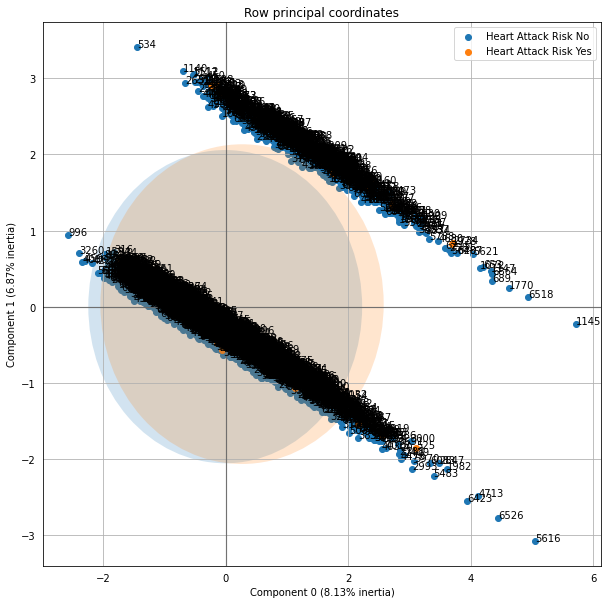

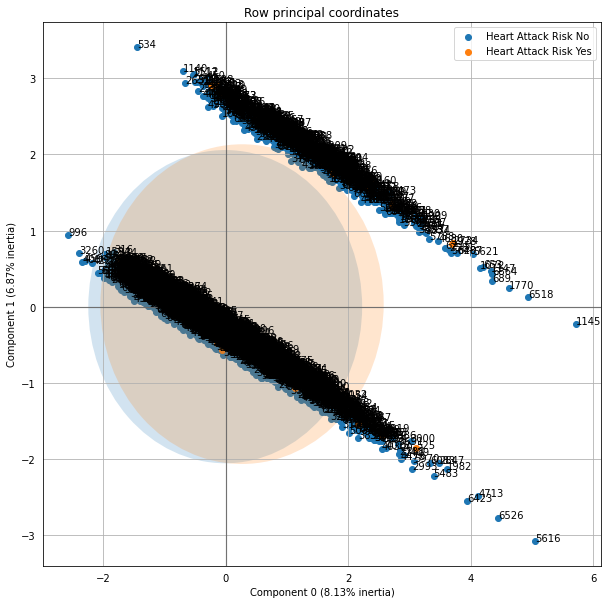

In [16]:
ax = famd.plot_row_coordinates(X_train,
ax=None, 
figsize=(10, 10), 
x_component=0, 
y_component=1, 
labels=X_train.index, 
color_labels=['Heart Attack Risk {}'.format(t) for t in y_train.values],
ellipse_outline=False, ellipse_fill=True, show_points=True)
ax.get_figure()

In [17]:
#Transform SMOTE and upsampled training data
X_train_os = famd.fit_transform(os_data_X)
X_train_upsampled_transformed = famd.fit_transform(X_train_upsampled)
X_train_imabalanced = famd.fit_transform(X_train)

Now that we have our training data transformed using FAMD, let's see what kind of supervised learning scores we get when trying to classify people as at risk of heart attack or not at risk of heart attack. Using both the data balanced using SMOTE and upsampling to see which performs better

In [18]:
#Helper functions to get model scores
def get_performance_scores(y_pred, y_true):
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return [f1, accuracy, precision, recall]

def print_performance_scores(scores):
    print("Accuracy Score = " + str(scores[1]))
    print("Precision Score = " + str(scores[2]))
    print("Recall Score = " + str(scores[3]))
    print("F1 Score = " + str(scores[0]))

In [19]:
X_test_transformed = famd.fit_transform(X_test)

#Logistic Regression Using Original Dataset
clf_lr = LogisticRegression(random_state = RANDOM_SEED, penalty='l2', class_weight = {'No': 0.75, 'Yes': 0.25},  C=0.25).fit(X_train_imabalanced, y_train)
train_preds = (clf_lr.predict_proba(X_test_transformed)[:,1] >= 0.8).astype(int)
train_preds = pd.DataFrame(train_preds, columns = ['val'])
train_preds = train_preds['val'].replace(to_replace = [0, 1], value = ['No', 'Yes'])

original_lr_scores = get_performance_scores(train_preds, y_test)
print_performance_scores(original_lr_scores)

#Logistic Regression Using SMOTE
clf_lr = LogisticRegression(random_state = RANDOM_SEED, penalty='l2', class_weight = {'No': 0.75, 'Yes': 0.25},  C=0.25).fit(X_train_os, os_data_y.values.ravel())
train_preds = (clf_lr.predict_proba(X_test_transformed)[:,1] >= 0.8).astype(int)
train_preds = pd.DataFrame(train_preds, columns = ['val'])
train_preds = train_preds['val'].replace(to_replace = [0, 1], value = ['No', 'Yes'])

smote_lr_scores = get_performance_scores(train_preds, y_test)
print_performance_scores(smote_lr_scores)

#Logistic Regression using upsampled data
clf_lr = LogisticRegression(random_state = RANDOM_SEED, penalty='l2', class_weight = {'No': 0.75, 'Yes': 0.25},  C=0.25).fit(X_train_upsampled_transformed, y_train_upsampled)
train_preds = (clf_lr.predict_proba(X_test_transformed)[:,1] >= 0.8).astype(int)
train_preds = pd.DataFrame(train_preds, columns = ['val'])
train_preds = train_preds['val'].replace(to_replace = [0, 1], value = ['No', 'Yes'])

upsampled_lr_scores = get_performance_scores(train_preds, y_test)
print_performance_scores(upsampled_lr_scores)
original_lr_scores.insert(0, 'Imbalanced')
smote_lr_scores.insert(0, 'Balanced Using SMOTE')
upsampled_lr_scores.insert(0, 'Upsampled using resample')

C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy Score = 0.9543707973102786
Precision Score = 0.4771853986551393
Recall Score = 0.5
F1 Score = 0.4883263701155075
Accuracy Score = 0.7521613832853026
Precision Score = 0.47140276941601444
Recall Score = 0.39406139909411175
F1 Score = 0.42927631578947373
Accuracy Score = 0.8904899135446686
Precision Score = 0.5542505608623877
Recall Score = 0.6018435621010251
F1 Score = 0.5663783748232432


In [20]:
#Random Forest Using Original Data
random_forest = RandomForestClassifier(n_estimators= 200, min_samples_split= 2, min_samples_leaf = 1, max_depth = None, bootstrap = False, random_state = RANDOM_SEED )
random_forest.fit(X_train_imabalanced, y_train)

y_pred = random_forest.predict(X_test_transformed)
    
original_rf_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(original_rf_scores)

#Random Forest Using SMOTE Data
random_forest = RandomForestClassifier(n_estimators= 200, min_samples_split= 2, min_samples_leaf = 1, max_depth = None, bootstrap = False, random_state = RANDOM_SEED )
random_forest.fit(X_train_os, os_data_y.values.ravel())

y_pred = random_forest.predict(X_test_transformed)
    
smote_rf_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(smote_rf_scores)

#Random Forest Using Upsampled Data
random_forest = RandomForestClassifier(n_estimators= 200, min_samples_split= 2, min_samples_leaf = 1, max_depth = None, bootstrap = False, random_state = RANDOM_SEED )
random_forest.fit(X_train_upsampled_transformed, y_train_upsampled)

y_pred = random_forest.predict(X_test_transformed)
    
upsampled_rf_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(upsampled_rf_scores)
original_rf_scores.insert(0, 'Imbalanced')
smote_rf_scores.insert(0, 'Balanced Using SMOTE')
upsampled_rf_scores.insert(0, 'Upsampled using resample')

C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy Score = 0.9543707973102786
Precision Score = 0.4771853986551393
Recall Score = 0.5
F1 Score = 0.4883263701155075
Accuracy Score = 0.9418828049951969
Precision Score = 0.4768968871595331
Recall Score = 0.4934574735782587
F1 Score = 0.4850358644570863
Accuracy Score = 0.9514889529298751
Precision Score = 0.4771194605009634
Recall Score = 0.4984901862103674
F1 Score = 0.4875707605217819


In [21]:
#SVC Using Original dataset
svc_model = SVC(C=100, gamma=0.1, kernel='poly', random_state=RANDOM_SEED).fit(X_train_imabalanced, y_train)
y_pred = svc_model.predict(X_test_transformed)
original_svc_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(original_svc_scores)

#SVC Using SMOTE dataset
svc_model = SVC(C=100, gamma=0.1, kernel='poly', random_state=RANDOM_SEED).fit(X_train_os, os_data_y.values.ravel())
y_pred = svc_model.predict(X_test_transformed)
smote_svc_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(smote_svc_scores)

#SVC Using Upsampled dataset
svc_model = SVC(C=100, gamma=0.1, kernel='poly', random_state=RANDOM_SEED).fit(X_train_upsampled_transformed, y_train_upsampled)
y_pred = svc_model.predict(X_test_transformed)
upsampled_svc_scores = get_performance_scores(y_pred, y_test)
print_performance_scores(upsampled_svc_scores)
original_svc_scores.insert(0, 'Imbalanced')
smote_svc_scores.insert(0, 'Balanced Using SMOTE')
upsampled_svc_scores.insert(0, 'Upsampled using resample')
print(upsampled_svc_scores)

Accuracy Score = 0.952449567723343
Precision Score = 0.5606936416184971
Recall Score = 0.5040049797367097
F1 Score = 0.4977178741748159
Accuracy Score = 0.7094140249759846
Precision Score = 0.47476893224975064
Recall Score = 0.3917119169337536
F1 Score = 0.4213380142900261
Accuracy Score = 0.9193083573487032
Precision Score = 0.5130106925093523
Recall Score = 0.5116997324715917
F1 Score = 0.5122489959839357
['Upsampled using resample', 0.5122489959839357, 0.9193083573487032, 0.5130106925093523, 0.5116997324715917]


In [22]:
scores_columns = ["Balancing Type", "F1 Score", "Accuracy Score", "Precision Score", "Recall Score"]
scores_rows = ["Logistic Regression", "Logistic Regression", "Logistic Regression", "Random Forest", "Random Forest", "Random Forest", "SVC", "SVC", "SVC"]
scores = [original_lr_scores, smote_lr_scores, upsampled_lr_scores, original_rf_scores, smote_rf_scores, upsampled_rf_scores, original_svc_scores, smote_svc_scores, upsampled_svc_scores]
print(scores)
scores_df = pd.DataFrame(data=scores, index=scores_rows, columns=scores_columns)
scores_df

[['Imbalanced', 0.4883263701155075, 0.9543707973102786, 0.4771853986551393, 0.5], ['Balanced Using SMOTE', 0.42927631578947373, 0.7521613832853026, 0.47140276941601444, 0.39406139909411175], ['Upsampled using resample', 0.5663783748232432, 0.8904899135446686, 0.5542505608623877, 0.6018435621010251], ['Imbalanced', 0.4883263701155075, 0.9543707973102786, 0.4771853986551393, 0.5], ['Balanced Using SMOTE', 0.4850358644570863, 0.9418828049951969, 0.4768968871595331, 0.4934574735782587], ['Upsampled using resample', 0.4875707605217819, 0.9514889529298751, 0.4771194605009634, 0.4984901862103674], ['Imbalanced', 0.4977178741748159, 0.952449567723343, 0.5606936416184971, 0.5040049797367097], ['Balanced Using SMOTE', 0.4213380142900261, 0.7094140249759846, 0.47476893224975064, 0.3917119169337536], ['Upsampled using resample', 0.5122489959839357, 0.9193083573487032, 0.5130106925093523, 0.5116997324715917]]


,Balancing Type,F1 Score,Accuracy Score,Precision Score,Recall Score
Logistic Regression,Imbalanced,0.488326,0.954371,0.477185,0.500000
Logistic Regression,Balanced Using SMOTE,0.429276,0.752161,0.471403,0.394061
Logistic Regression,Upsampled using resample,0.566378,0.890490,0.554251,0.601844
Random Forest,Imbalanced,0.488326,0.954371,0.477185,0.500000
Random Forest,Balanced Using SMOTE,0.485036,0.941883,0.476897,0.493457
Random Forest,Upsampled using resample,0.487571,0.951489,0.477119,0.498490
SVC,Imbalanced,0.497718,0.952450,0.560694,0.504005
SVC,Balanced Using SMOTE,0.421338,0.709414,0.474769,0.391712
SVC,Upsampled using resample,0.512249,0.919308,0.513011,0.511700


In [23]:
fig = px.bar(scores_df, x=scores_df.index, y="F1 Score",
             color='Balancing Type', barmode='group', title="F1 Score By Model And Balance Type", text_auto='.3', 
             labels={"index": "Supervised Learning Model", "Balancing Type": "Balancing Method"},
             height=400)
fig.update_layout(title_text='F1 Score By Model And Balancing Method', title_x=0.5)
fig.update_yaxes(range=[0, 1])
fig.show()

Since the logistic regression model performed the best, let's see what the feature importance for that model is

In [24]:
#Get feature importance
from operator import itemgetter
column_arr = X_train_upsampled_transformed.columns
features_coeff = dict(zip(column_arr, clf_lr.coef_[0]))
features_coeff_abs = {str(key) : abs(val) for key, val in features_coeff.items()}
features_coeff_abs_top_10 = dict(sorted(features_coeff_abs.items(), key = itemgetter(1), reverse = True)[:10])
print(features_coeff_abs_top_10)
features_dict = {'Components': list(features_coeff_abs_top_10.keys()), 'coeffs': list(features_coeff_abs_top_10.values())}
fig = px.bar(features_dict, x='Components', y='coeffs')
fig.show()

{'2': 2.328866552891288, '3': 1.5346985689637216, '81': 1.0030158226536554, '36': 0.8934596354674901, '11': 0.8812507798448257, '103': 0.8151397783525837, '26': 0.808254019726121, '64': 0.797892009321901, '89': 0.7859509012925077, '78': 0.6460925576363215}


Overall the performance is better when we upsample the data using the resample library than when we use SMOTE. We can try using upsampling with a different selection of initial columns to run FAMD to see if the results change. One way to select columns differently is by calcultating which columns have the highest correlation with the target variable.

In [25]:
# Step 5: Encode categorical variables as numeric to calculate correlations
df_clean_categorical = df_clean.copy()
cols = list(df_clean_categorical.columns)
for col in cols:
    if str(df_clean_categorical[col].dtype) == 'object':
        df_clean_categorical[col] = df_clean_categorical[col].astype('category').cat.codes

df_clean.head()

,_STATE,IDATE,IMONTH,IDAY,IYEAR,SEQNO,_PSU,CELLSEX,SEXVAR,GENHLTH,...,WTRSOURCE,STRSMEAL,FRUITVEG,MJUSE30,MJNYSMMP,HEPCTEST,HEPCTOLD,_WT2SPLITS,REGION,DSRIPREG
0,New York,1152020,1,15,2020,2020002528,2020002528,NaN,Male,Very good,...,Public Water Supply,Always,NaN,None,No,No,No,5130.843243,NYS exclusive of NYC,Long Island
1,New York,1302020,1,30,2020,2020002529,2020002529,NaN,Male,Very good,...,Public Water Supply,Never,NaN,None,No,No,No,941.550458,NYS exclusive of NYC,Long Island
2,New York,1152020,1,15,2020,2020002530,2020002530,NaN,Female,Good,...,Public Water Supply,Never,NaN,None,No,No,No,3497.366203,NYS exclusive of NYC,Long Island
3,New York,2032020,2,3,2020,2020004509,2020004509,NaN,Female,Good,...,Public Water Supply,Never,Neighborhood,None,No,NaN,NaN,1187.709030,NYS exclusive of NYC,Long Island
4,New York,2152020,2,15,2020,2020002531,2020002531,NaN,Male,Fair,...,Don't Know/Not Sure,Rarely,NaN,None,No,No,No,13364.387863,NYS exclusive of NYC,Long Island


In [26]:
#Step 7: Create correlation matrix to find which features to use for mca
df_clean_corr = df_clean_categorical.corrwith(df_clean_categorical["CVDCRHD4"])
df_clean_corr_abs = df_clean_corr.abs()
df_clean_corr_abs.sort_values(inplace=True, ascending=False)
df_clean_corr_abs

CVDCRHD4    1.000000
_MICHD      0.715660
CVDINFR4    0.402811
_AGE80      0.170806
_PNEUMO3    0.170164
              ...   
CNCRTYP1    0.006616
_MENT14D    0.003607
SLEPTIM1    0.002435
IDAY        0.000817
_STATE           NaN
Length: 164, dtype: float64

In [27]:
feature_list = list(df_clean_corr_abs[0:100].keys())
feature_list.remove('CVDINFR4')
feature_list.remove('_MICHD')
feature_list

df_clean_columns = df_clean[feature_list]
df_clean_columns.head()

,CVDCRHD4,_AGE80,_PNEUMO3,_RFHLTH,_FLSHOT7,_AGE_G,_IMPAGE,_AGEG5YR,DIABETE4,_DRDXAR2,...,LASTDEN4,WTRSOURCE,ADDEPEV3,_IMPMRTL,_RACEGR3,STRSMEAL,DRNKANY5,_BMI5CAT,_PRACE1,_MRACE1
0,No,Imputed Age 65 to 69,No,Good or Better Health,Yes,Age 65 or older,Age 65 or older,Age 65 to 69,No,Not diagnosed with arthritis,...,Within the past year (anytime less than 12 mon...,Public Water Supply,No,Married,"Other race only, Non-Hispanic",Always,Yes,Obese,Asian,Asian Only
1,No,Imputed Age 55 to 59,Age Less Than 65,Good or Better Health,Age Less Than 65,Age 55 to 64,Age 55 to 64,Age 55 to 59,No,Not diagnosed with arthritis,...,Within the past year (anytime less than 12 mon...,Public Water Supply,No,Married,"White only, Non-Hispanic",Never,Yes,Obese,White,White only
2,No,Imputed Age 80 or older,Yes,Good or Better Health,Yes,Age 65 or older,Age 65 or older,Age 80 or older,Yes,Diagnosed with arthritis,...,Within the past year (anytime less than 12 mon...,Public Water Supply,No,Widowed,"White only, Non-Hispanic",Never,No,Normal Weight,White,White only
3,No,Imputed Age 80 or older,Yes,Good or Better Health,Yes,Age 65 or older,Age 65 or older,Age 80 or older,No,Diagnosed with arthritis,...,Within the past year (anytime less than 12 mon...,Public Water Supply,Yes,Widowed,"White only, Non-Hispanic",Never,Yes,Overweight,White,White only
4,No,Imputed Age 40 to 44,Age Less Than 65,Fair or Poor Health,Age Less Than 65,Age 35 to 44,Age 35 to 44,Age 40 to 44,Yes,Not diagnosed with arthritis,...,Within the past year (anytime less than 12 mon...,Don't Know/Not Sure,Yes,Married,Hispanic,Rarely,No,Overweight,Other race,Other race only


In [28]:
from sklearn.model_selection import train_test_split 

# Drop all missing values
df_cleaned = df_clean_columns.dropna(axis = 0).reset_index(drop = True)

# Drop all rows that are Don't know/Not sure or Refused for column we are predicting
df_cleaned = df_cleaned.loc[(df_cleaned['CVDCRHD4'] == 'No') | (df_cleaned['CVDCRHD4'] == 'Yes')]

# Split into X and y
X = df_cleaned.loc[:, df_cleaned.columns != 'CVDCRHD4']
y = df_cleaned['CVDCRHD4']

# Split the data into training and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3,random_state = 42)

In [29]:
dummy_clf = DummyClassifier(strategy= 'uniform').fit(famd.fit_transform(X_train),y_train)
y_pred = dummy_clf.predict(famd.fit_transform(X_test))
print_performance_scores(get_performance_scores(y_pred, y_test))

Accuracy Score = 0.5026178010471204
Precision Score = 0.481978021978022
Recall Score = 0.4236499068901304
F1 Score = 0.368584055398963


In [30]:
famd = FAMD(n_components = 120, n_iter = 3, random_state = 42)
X_train_transformed = famd.fit_transform(X_train)
X_test_transformed = famd.fit_transform(X_test)
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
338,-0.739776,-0.401484,0.570149,0.963322,-0.393796,-0.758660,0.240287,-0.118573,0.224769,-0.071371,...,0.047995,0.087669,0.075351,-0.102864,-0.009134,-0.055911,-0.032490,-0.057126,0.065112,-0.036606
69,0.554355,0.767123,-1.204310,1.628355,-0.026129,-0.153126,-0.561553,0.071393,0.294068,-0.217709,...,-0.083091,-0.101157,-0.141479,0.140969,-0.019070,0.047056,0.187828,0.112193,0.060879,0.109600
580,1.497992,1.123102,1.304938,0.104005,-0.437897,0.492765,-0.594053,0.466385,-0.160858,0.155420,...,-0.062684,-0.052728,-0.024044,-0.002245,0.240972,0.159652,0.108026,0.086674,-0.221100,-0.207705
595,-0.285386,0.399521,-0.222701,-0.757480,-0.703774,0.016624,-0.115683,-0.064204,0.291958,0.065415,...,0.110256,0.010897,-0.036051,-0.002512,-0.066673,-0.029631,0.016489,0.044393,-0.018649,-0.144122
191,0.724229,-0.036783,-0.259528,-1.207719,0.573633,0.286958,-0.072805,-0.079832,-0.062634,0.108560,...,0.037036,-0.003162,-0.140890,0.155790,-0.006583,-0.028848,-0.020135,-0.029866,-0.051084,0.062748


In [31]:
training_data = pd.DataFrame(X_train)
training_data['CVDCRHD4'] = y_train
df_majority = training_data[(training_data['CVDCRHD4']=='No')] 
df_minority = training_data[(training_data['CVDCRHD4']=='Yes')] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_majority), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
X_train_upsampled = df_upsampled.loc[:, df_cleaned.columns != 'CVDCRHD4']
y_train_upsampled = df_upsampled['CVDCRHD4']

In [32]:
X_train_upsampled_transformed = famd.fit_transform(X_train_upsampled)
clf_lr = LogisticRegression(random_state = RANDOM_SEED, penalty='l2', class_weight = {'No': 0.75, 'Yes': 0.25},  C=0.25).fit(X_train_upsampled_transformed, y_train_upsampled)
train_preds = (clf_lr.predict_proba(X_test_transformed)[:,1] >= 0.8).astype(int)
train_preds = pd.DataFrame(train_preds, columns = ['val'])
train_preds = train_preds['val'].replace(to_replace = [0, 1], value = ['No', 'Yes'])

upsampled_lr_scores_correlated = get_performance_scores(train_preds, y_test)
print_performance_scores(upsampled_lr_scores_correlated)

Accuracy Score = 0.8586387434554974
Precision Score = 0.5631469979296067
Recall Score = 0.6135940409683426
F1 Score = 0.5753808151502675


In [33]:
#Get feature importance
from operator import itemgetter
column_arr = X_train_upsampled_transformed.columns
features_coeff = dict(zip(column_arr, clf_lr.coef_[0]))
features_coeff_abs = {str(key) : abs(val) for key, val in features_coeff.items()}
features_coeff_abs_top_10 = dict(sorted(features_coeff_abs.items(), key = itemgetter(1), reverse = True)[:10])
print(features_coeff_abs_top_10)
features_dict = {'Components': list(features_coeff_abs_top_10.keys()), 'coeffs': list(features_coeff_abs_top_10.values())}
fig = px.bar(features_dict, x='Components', y='coeffs', text_auto='.3')
fig.update_layout(title_text='Feature Importance: Top 10 Feature Coefficients', title_x=0.5)
fig.show()

{'7': 2.0496595542029534, '5': 2.0051614714136208, '10': 1.4221928963893917, '21': 1.2196824374515267, '8': 1.032107237945042, '12': 0.9102059913875434, '2': 0.9040738029885392, '6': 0.8325558676984646, '19': 0.7150891903903567, '20': 0.5653442620024358}


In [44]:
famd_correlations_comp_7 = famd.column_correlations(X_train)[7]
famd_correlations_comp_7_abs = famd_correlations_comp_7.abs()
famd_correlations_comp_7_top_20_labels = list(famd_correlations_comp_7_abs.sort_values(ascending=False)[0:10].index.values)
famd_correlations_comp_7_top_10 = famd_correlations_comp_7.loc[famd_correlations_comp_7_top_20_labels]
famd_correlations_top_10_labels_7 = list(famd_correlations_comp_7_top_10.index.values)
famd_correlations_top_10_values_7 = list(famd_correlations_comp_7_top_10.values)
famd_correlations_top_10_values_7


famd_correlations_comp_5 = famd.column_correlations(X_train)[5]
famd_correlations_comp_5_abs = famd_correlations_comp_5.abs()
famd_correlations_comp_5_top_20_labels = list(famd_correlations_comp_5_abs.sort_values(ascending=False)[0:10].index.values)
famd_correlations_comp_5_top_10 = famd_correlations_comp_5.loc[famd_correlations_comp_5_top_20_labels]
famd_correlations_top_10_labels_5 = list(famd_correlations_comp_5_top_10.index.values)
famd_correlations_top_10_values_5 = list(famd_correlations_comp_5_top_10.values)
famd_correlations_top_10_values_5

famd_correlations_comp_10 = famd.column_correlations(X_train)[10]
famd_correlations_comp_10_abs = famd_correlations_comp_10.abs()
famd_correlations_comp_10_top_20_labels = list(famd_correlations_comp_10_abs.sort_values(ascending=False)[0:10].index.values)
famd_correlations_comp_10_top_10 = famd_correlations_comp_10.loc[famd_correlations_comp_10_top_20_labels]
famd_correlations_top_10_labels_10 = list(famd_correlations_comp_10_top_10.index.values)
famd_correlations_top_10_values_10 = list(famd_correlations_comp_10_top_10.values)
famd_correlations_top_10_values_10

[-0.9195546936118473,
 -0.9195546936118473,
 -0.8106109963689592,
 -0.33459872653036116,
 -0.26074851395737303,
 0.2607485139573728,
 -0.2356649889626911,
 -0.21269833059981066,
 0.1922379053969604,
 -0.19035397782544064]

In [45]:
print(famd_correlations_comp_7_top_10)
print(famd_correlations_comp_5_top_10)
print(famd_correlations_comp_10_top_10)

SEQNO                                    0.812344
_PSU                                     0.812344
QSTVER                                   0.721035
_LLCPWT                                 -0.465732
_WT2SPLITS                              -0.447393
WTKG3                                    0.415690
_BMI5CAT_Obese                           0.262312
CNCRAGE_Age in years (97=97 or older)    0.243847
CNCRAGE_Missing                         -0.243847
_RFBMI5_No                              -0.240833
Name: 7, dtype: float64
WTKG3                     0.904989
_BMI5CAT_Obese            0.663032
_RFBMI5_Yes               0.594442
_RFBMI5_No               -0.586241
_BMI5CAT_Normal Weight   -0.530764
SEQNO                    -0.381714
_PSU                     -0.381714
QSTVER                   -0.321826
DIABETE4_No              -0.216376
PHYSHLTH_None            -0.206389
Name: 5, dtype: float64
_PSU                                    -0.919555
SEQNO                                   -0.919555
QS

In [49]:
labels_7 = ['ANNUAL SEQUENCE NUMBER', 'PRIMARY SAMPLING UNIT', 'QUESTIONNAIRE VERSION IDENTIFIER', 'FINAL WEIGHT: LAND-LINE AND CELL-PHONE DATA', 'Final Adjusted Weight for Content on Two of Three Splits','COMPUTED WEIGHT IN KILOGRAMS', 'OVERWEIGHT OR OBESE - OBESE', 'AGE TOLD HAD CANCER - >= 97', 'AGE TOLD HAD CANCER - MISSING', 'OVERWEIGHT OR OBESE CALCULATED VARIABLE - No']
fig = go.Figure(data=go.Heatmap(
        z=[famd_correlations_top_10_values_1],
        x=labels_7,
        y=['Component 7'],
        colorscale='Viridis'))
fig.show()

In [50]:
labels_5 = ['COMPUTED WEIGHT IN KILOGRAMS', 'COMPUTED BODY MASS INDEX CATEGORIES - OBESE', 'OVERWEIGHT OR OBESE CALCULATED VARIABLE - Yes', 'OVERWEIGHT OR OBESE CALCULATED VARIABLE - No', 'COMPUTED BODY MASS INDEX CATEGORIES - NORMAL WEIGHT', 'ANNUAL SEQUENCE NUMBER', 'PRIMARY SAMPLING UNIT', 'QUESTIONNAIRE VERSION IDENTIFIER', 'TOLD YOU HAVE DIABETES - No', 'NUMBER OF DAYS PHYSICAL HEALTH NOT GOOD - None']
fig = go.Figure(data=go.Heatmap(
        z=[famd_correlations_top_10_values_5],
        x=labels_5,
        y=['Component 5'],
        colorscale='Viridis'))
fig.show()

In [31]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=70, min_samples_split=10, n_estimators=1000, random_state=42)
random_forest.fit(X_train_upsampled_transformed, y_train_upsampled)

y_pred = random_forest.predict(X_test_transformed)
    
upsampled_rf_scores_correlated = get_performance_scores(y_pred, y_test)
print_performance_scores(upsampled_rf_scores_correlated)

Accuracy Score = 0.93717277486911
Precision Score = 0.468586387434555
Recall Score = 0.5
F1 Score = 0.4837837837837838


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [32]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train_upsampled_transformed, y_train_upsampled)

grid_values = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 }

rand_search_clf = RandomizedSearchCV(estimator = rf_clf, param_distributions = grid_values, n_iter = 10, cv = 3, verbose=2, scoring='f1_macro', random_state=RANDOM_SEED, n_jobs = -1)

my_list = list(range(100))
for x in tqdm(my_list):
    rand_search_clf.fit(X_train_upsampled_transformed[0:10000], y_train_upsampled[0:10000])
print(rand_search_clf.best_estimator_)'''

"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\n\nrf_clf = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train_upsampled_transformed, y_train_upsampled)\n\ngrid_values = {'bootstrap': [True, False],\n 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],\n 'max_features': ['auto', 'sqrt'],\n 'min_samples_leaf': [1, 2, 4],\n 'min_samples_split': [2, 5, 10],\n 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]\n }\n\nrand_search_clf = RandomizedSearchCV(estimator = rf_clf, param_distributions = grid_values, n_iter = 10, cv = 3, verbose=2, scoring='f1_macro', random_state=RANDOM_SEED, n_jobs = -1)\n\nmy_list = list(range(100))\nfor x in tqdm(my_list):\n    rand_search_clf.fit(X_train_upsampled_transformed[0:10000], y_train_upsampled[0:10000])\nprint(rand_search_clf.best_estimator_)"

In [33]:

'''param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = RandomizedSearchCV(SVC(random_state=RANDOM_SEED),param_grid,refit=True,verbose=2, scoring='f1_macro')

my_list = list(range(100))
for x in tqdm(my_list):
    grid.fit(X_train_transformed[0:10000],y_train_upsampled[0:10000])

print(grid.best_estimator_)'''

"param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}\n\ngrid = RandomizedSearchCV(SVC(random_state=RANDOM_SEED),param_grid,refit=True,verbose=2, scoring='f1_macro')\n\nmy_list = list(range(100))\nfor x in tqdm(my_list):\n    grid.fit(X_train_transformed[0:10000],y_train_upsampled[0:10000])\n\nprint(grid.best_estimator_)"

In [34]:
'''#Do grid search for hyperparameter tuning
clf = LogisticRegression(random_state = RANDOM_SEED, solver='liblinear')
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1_macro')
my_list = list(range(100))
for x in tqdm(my_list):
    grid_clf_acc.fit(X_train_transformed, y_train)

y_pred_acc = grid_clf_acc.predict(X_test_transformed)

print_performance_scores(get_performance_scores(y_pred_acc, y_test))'''

"#Do grid search for hyperparameter tuning\nclf = LogisticRegression(random_state = RANDOM_SEED, solver='liblinear')\ngrid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}\ngrid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1_macro')\nmy_list = list(range(100))\nfor x in tqdm(my_list):\n    grid_clf_acc.fit(X_train_transformed, y_train)\n\ny_pred_acc = grid_clf_acc.predict(X_test_transformed)\n\nprint_performance_scores(get_performance_scores(y_pred_acc, y_test))"

In [35]:
svc_model = SVC(C=100, gamma=0.1, kernel='poly', random_state=RANDOM_SEED).fit(X_train_upsampled_transformed, y_train_upsampled)
y_pred = svc_model.predict(X_test_transformed)
upsampled_svc_scores_correlated = get_performance_scores(y_pred, y_test)
print_performance_scores(upsampled_svc_scores_correlated)

Accuracy Score = 0.8952879581151832
Precision Score = 0.5817191283292978
Recall Score = 0.5942737430167597
F1 Score = 0.587294727744166


In [41]:
upsampled_lr_scores.remove("Upsampled using resample")
upsampled_rf_scores.remove("Upsampled using resample")
upsampled_svc_scores.remove("Upsampled using resample")
upsampled_lr_scores.insert(0, "Manually Selected Columns")
upsampled_rf_scores.insert(0, "Manually Selected Columns")
upsampled_svc_scores.insert(0, "Manually Selected Columns")
upsampled_lr_scores_correlated.insert(0, "Most Correlated Columns")
upsampled_rf_scores_correlated.insert(0, "Most Correlated Columns")
upsampled_svc_scores_correlated.insert(0, "Most Correlated Columns")
scores_columns = ["Input Columns", "F1 Score", "Accuracy Score", "Precision Score", "Recall Score"]
scores_rows = ["Logistic Regression", "Logistic Regression", "Random Forest", "Random Forest", "SVC", "SVC"]
scores = [upsampled_lr_scores, upsampled_lr_scores_correlated, upsampled_rf_scores, upsampled_rf_scores_correlated, upsampled_svc_scores, upsampled_svc_scores_correlated]
print(scores)
scores_df = pd.DataFrame(data=scores, index=scores_rows, columns=scores_columns)
scores_df

fig = px.bar(scores_df, x=scores_df.index, y="F1 Score",
             color='Input Columns', barmode='group', title="F1 Score By Model And Balance Type", text_auto='.3', 
             labels={"index": "Supervised Learning Model", "Input Columns": "Initial Column Selection"},
             height=400)
fig.update_layout(title_text='F1 Score By Model And Column Selection Method', title_x=0.5)
fig.update_yaxes(range=[0, 1])
fig.show()

[['Manually Selected Columns', 0.5663783748232432, 0.8904899135446686, 0.5542505608623877, 0.6018435621010251], ['Most Correlated Columns', 0.5802907369844489, 0.8638743455497382, 0.5672404518558365, 0.6163873370577281], ['Manually Selected Columns', 0.4875707605217819, 0.9514889529298751, 0.4771194605009634, 0.4984901862103674], ['Most Correlated Columns', 0.4837837837837838, 0.93717277486911, 0.468586387434555, 0.5], ['Manually Selected Columns', 0.5122489959839357, 0.9193083573487032, 0.5130106925093523, 0.5116997324715917], ['Most Correlated Columns', 0.587294727744166, 0.8952879581151832, 0.5817191283292978, 0.5942737430167597]]
